In [2]:
import cv2
import pandas as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import mediapipe as mp

In [3]:
import glob
import random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import seaborn as sns
import mediapipe as mp
import warnings

In [4]:
def draw_poses(img,other):
    pass

In [5]:
os.getcwd()

'C:\\Users\\MAHIREDDY\\OneDrive\\Desktop\\Internships_2024\\SSN_summer_research_internship_2024'

In [10]:
path='C:\\Users\\MAHIREDDY\\OneDrive\\Desktop\\Internships_2024\\SSN_summer_research_internship_2024\\CP-LFW\\images\\images'

In [11]:
image_paths=[]
cnt=0
for img_path in os.scandir(path):
    image_paths.append(img_path.path)
    if cnt==10:
        break
    cnt+=1

In [12]:
images=[]

for img_path in image_paths:
    img=cv2.imread(img_path)
    images.append(img)

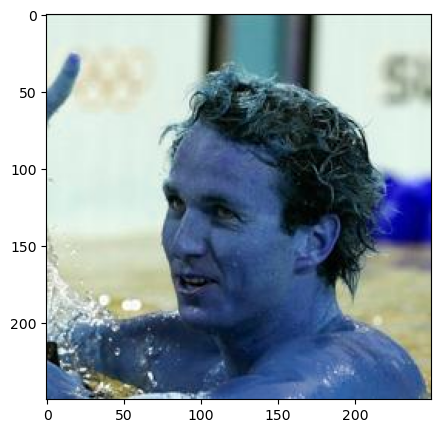

In [13]:
plt.figure(figsize=(15,5))
plt.imshow(images[7])

In [14]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

In [ ]:
import cv2
import mediapipe as mp
import math

def get_head_pose_angle(image_array):
    # Initialize MediaPipe pose model
    mp_pose = mp.solutions.pose
    pose_detection = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    # Convert image array to mediapipe image
    image = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)

    # Get pose landmarks
    pose_results = pose_detection.process(cv2.cvtColor(image.numpy_view(), cv2.COLOR_RGB2BGR))
    landmarks = pose_results.pose_landmarks

    # Check if pose landmarks are available
    if landmarks is not None:
        # Get nose landmark
        nose = landmarks.landmark[mp_pose.PoseLandmark.NOSE]

        # Get left and right shoulder landmarks
        left_shoulder = landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]

        # Calculate rotation matrix
        rotation_matrix = cv2.Rodrigues(np.array([[left_shoulder.y - right_shoulder.y, right_shoulder.x - left_shoulder.x, nose.z - (left_shoulder.x + right_shoulder.x) / 2]]))[0]

        # Calculate Euler angles
        sy = math.sqrt(rotation_matrix[0,0] * rotation_matrix[0,0] +  rotation_matrix[1,0] * rotation_matrix[1,0])
        singular = sy < 1e-6
        if not singular:
            x = math.atan2(rotation_matrix[2,1] , rotation_matrix[2,2])
            y = math.atan2(-rotation_matrix[2,0], sy)
            z = math.atan2(rotation_matrix[1,0], rotation_matrix[0,0])
        else:
            x = math.atan2(-rotation_matrix[1,2], rotation_matrix[1,1])
            y = math.atan2(-rotation_matrix[2,0], sy)
            z = 0

        # Convert Euler angles to degrees
        x = x * 180 / math.pi
        y = y * 180 / math.pi
        z = z * 180 / math.pi

        # Return head pose angle
        return x,y,z

    # Return None if pose landmarks are not available
    return None

In [ ]:
img = images[7]

# Convert the angles to degrees and normalize to [0, 180] range if necessary
yaw, pitch, roll = get_head_pose_angle(img)
print(f"Yaw: {yaw:.2f}, Pitch: {pitch:.2f}, Roll: {roll:.2f}")

In [24]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [ ]:

random_file = 'image00379'
# Define the paths to the image and MAT file
image_path = f'{directory}/{random_file}.jpg'
mat_file_path = f'{directory}/{random_file}.mat'

# Load the image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is not None:
    # Load the MAT file to extract the 3 angles of the face (pitch, yaw, roll)
    mat_file = sio.loadmat(mat_file_path)

    # Extract the labels for the 3 angles
    pose_para = mat_file["Pose_Para"][0][:3]
    pitch, yaw, roll = pose_para[0], pose_para[1], pose_para[2]
    
    # Draw axes on the image
    image_with_axes = draw_axis(image, pitch, yaw, roll)

    # Display the image with axes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

else:
    print(f"Error: Unable to load the image from {image_path}.")

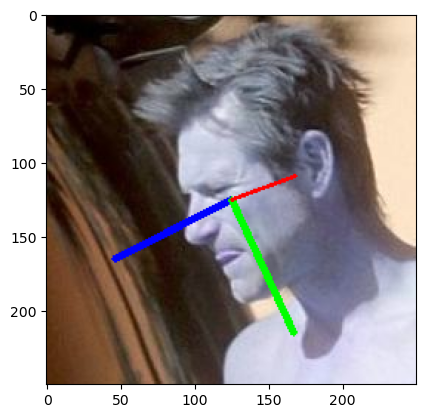

In [41]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

# Function to calculate rotation angles from face landmarks
def get_rotation_angles(landmarks):
    # Define the indices of the landmarks for nose tip, left eye, and right eye
    nose_tip = landmarks[1]
    left_eye = landmarks[33]
    right_eye = landmarks[263]

    # Calculate the vectors
    left_right_vector = np.array(right_eye) - np.array(left_eye)
    nose_vector = np.array(nose_tip) - (np.array(left_eye) + np.array(right_eye)) / 2

    # Calculate yaw, pitch, and roll
    yaw = np.arctan2(left_right_vector[1], left_right_vector[0])
    pitch = np.arctan2(nose_vector[2], nose_vector[1])
    roll = np.arctan2(left_right_vector[2], left_right_vector[0])

    # Convert radians to degrees
    yaw = np.degrees(yaw)
    pitch = np.degrees(pitch)
    roll = np.degrees(roll)

    return yaw, pitch, roll

frame=images[1]
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# Process the image and find face landmarks
results = face_mesh.process(rgb_frame)
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        landmarks = []
        for landmark in face_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y, landmark.z])
        # Calculate the rotation angles
        yaw, pitch, roll = get_rotation_angles(landmarks)
        # Display the angles on the frame
        print(f'Yaw:{yaw:.2f}, pitch{pitch:.2f} ,roll{roll:.2f}')
        frame=draw_axis(frame,pitch,yaw,roll)
# Display the frame
plt.imshow( frame)
cv2.waitKey(1)
cv2.destroyAllWindows()
